In [91]:
import typing

import polyflexmd.data_analysis.plot.msd as plot_msd
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.transform.msd as msd_transform
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick label
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (9,7)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
PATH_REL_ETE = "data/processed/ete.csv"

In [93]:
def aggregate_time_mean_ete(df_ete: pd.DataFrame, time_bucket_size: int, var_index: list[str]) -> pd.DataFrame:
    df_ete_agg =  df_ete.groupby(var_index+["molecule-ID", df_ete.index.get_level_values("t") // time_bucket_size], as_index=True).agg(np.mean)
    df_ete_agg.reset_index(level="t", drop=False, inplace=True)
    df_ete_agg["t"] = df_ete_agg["t"]*time_bucket_size
    df_ete_agg.set_index("t", append=True, inplace=True)
    return df_ete_agg


def get_dataset_ete_equi(
        conf: config.ExperimentConfig,
        experiment_path: pathlib.Path,
        var_index: list[str]
) -> pd.DataFrame:
    df = pd.read_csv(experiment_path / PATH_REL_ETE, index_col=var_index + ["molecule-ID", "t"])
    return df.loc[df.index.get_level_values("t") >= conf.simulation_config.variables["n_relax_steps"]]

## EEA1+Rab5

In [94]:
PATH_EXPERIMENT_CONNECTED = pathlib.Path("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/15-EEA1_short+Rab5_10x/b7015f55")
PATH_EXPERIMENT_CONNECTED

PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/15-EEA1_short+Rab5_10x/b7015f55')

In [95]:
CONF_CONNECTED = config.read_experiment_config(next(PATH_EXPERIMENT_CONNECTED.glob("*.toml")))
CONF_CONNECTED

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='144:00:00', partition='romeo', nodes=1, tasks_per_node=125, ntasks=125, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/beegfs/ws/0/s4610340-polyflexmd/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results'), n_partitions=1, n_tasks_per_partition=125, variables={'kappa_start': 190.2, 'kappa_delta': 0.0, 'kappa_n_values': 1, 'm_end': 1.5, 'd_end_start': 15, 'd_end_delta': 0.0, 'd_end_n_values': 1, 'n_relax_steps': 20000000, 'n_equilibrium_steps_1': 2000000, 'dump_frequency_1': 100, 'n_equilibrium_steps_2': 28000000, 'dump_frequency_2': 10000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpo

### Get data

#### ETE

In [96]:
df_ete_conn = aggregate_time_mean_ete(get_dataset_ete_equi(CONF_CONNECTED, PATH_EXPERIMENT_CONNECTED, var_index=["kappa", "d_end"]), time_bucket_size=1, var_index=["kappa", "d_end"])
df_ete_conn

R_x        R_y        R_z          R
kappa d_end molecule-ID t                                                   
190.2 15.0  1           20000000 -33.747601  18.192801 -45.704102  59.655205
                        20000100 -33.828400  17.974600 -45.742100  59.663947
                        20000200 -33.802299  17.854900 -45.730000  59.603907
                        20000300 -33.849800  17.888500 -45.611401  59.550040
                        20000400 -33.844700  17.890800 -45.696201  59.612811
...                                     ...        ...        ...        ...
            1000        49960000 -21.885401  54.804600  -1.491340  59.031678
                        49970000 -21.317801  54.397400  -0.458526  58.427185
                        49980000 -23.540001  53.861401  -1.014180  58.789546
                        49990000 -24.158300  53.656898  -1.617420  58.866818
                        50000000 -26.087900  52.334801   0.103927  58.476668

[22801000 rows x 4 columns]

<Axes: xlabel='t', ylabel='R'>

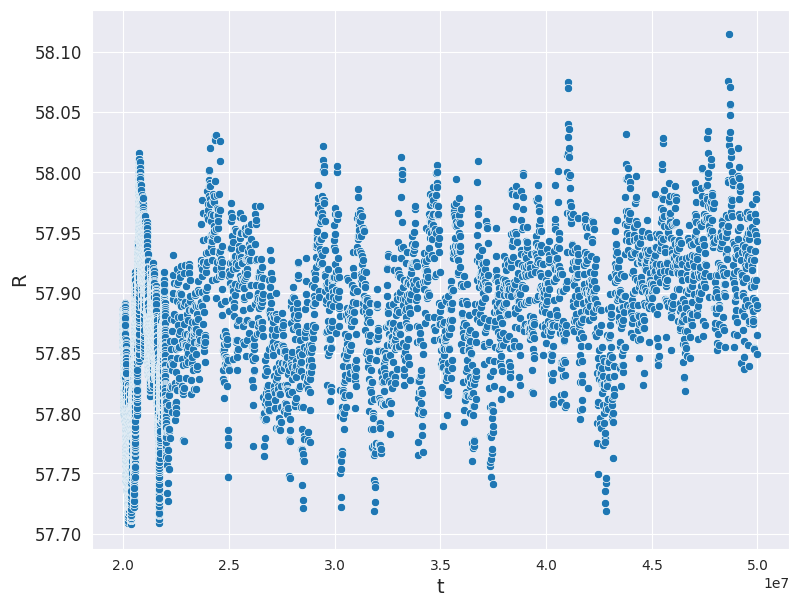

In [97]:
sns.scatterplot(
    df_ete_conn.groupby(["kappa", "d_end", "t"])["R"].mean().reset_index(),
    x="t",
    y="R",
)

#### Main axis

In [98]:
df_main_ax_conn = pd.read_csv(
    PATH_EXPERIMENT_CONNECTED / "data" / "processed" / "main_axis.csv"
).groupby("molecule-ID", as_index=True).nth(1)
df_main_ax_conn

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,-0.159927,-0.017451,-0.956566,0,0,0
3,2,1,-0.483684,-0.375608,0.752242,0,0,0
5,3,1,-0.036845,0.008633,0.969262,0,0,0
7,4,1,-0.050426,0.667705,-0.701803,0,0,0
9,5,1,-0.117898,0.182993,0.945258,0,0,0
...,...,...,...,...,...,...,...,...
1991,996,1,0.815395,0.492707,-0.182400,0,0,0
1993,997,1,0.373337,-0.191865,0.874475,0,0,0
1995,998,1,0.340244,-0.276341,-0.865315,0,0,0
1997,999,1,-0.260711,0.095793,0.929383,0,0,0


#### Kuhn length $l_K$

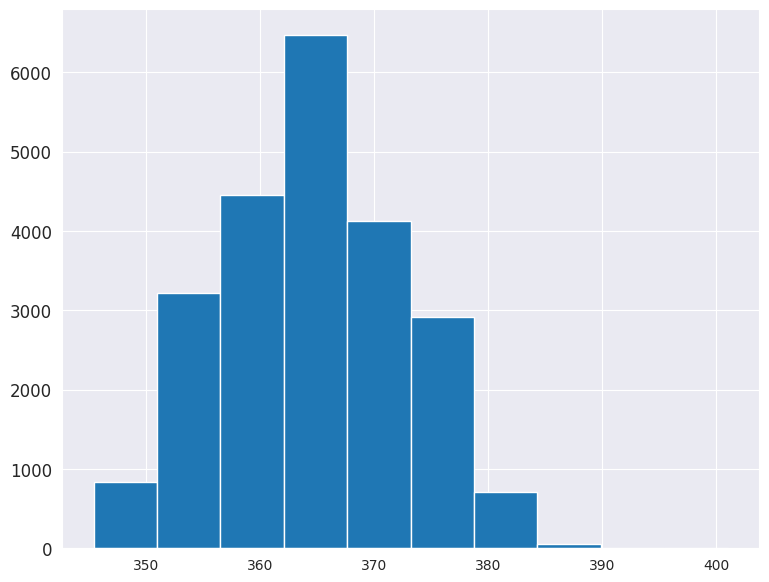

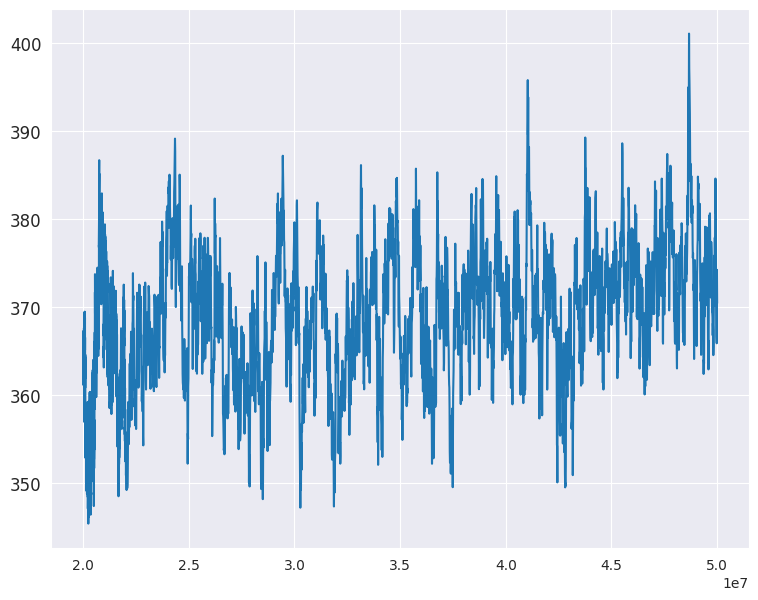

l_K        364.661935
std_l_K      7.896816
d_l_K       23.690447
Name: value, dtype: float64

In [99]:
def get_l_K_estimate(path_experiment: pathlib.Path):
    df_l_K_estimate: pd.Series = pd.read_csv(path_experiment / "data" / "processed" / "l_K-estimate.csv")
    plt.hist(df_l_K_estimate["l_K"]),
    plt.show()
    plt.plot(df_l_K_estimate["t"], df_l_K_estimate["l_K"])
    plt.show()
    l_K = df_l_K_estimate["l_K"].mean()
    std_l_K = df_l_K_estimate["l_K"].std()
    return pd.Series({
        "l_K": l_K,
        "std_l_K": std_l_K,
        "d_l_K": 3*std_l_K
    }, name="value")

l_K_estimate_conn = get_l_K_estimate(PATH_EXPERIMENT_CONNECTED)
l_K_estimate_conn

#### Bond length $l_b$

In [100]:
l_b = CONF_CONNECTED.initial_system_config.system_config.bond_length
l_b

#### Contour length L

In [101]:
L_contour = l_b*(CONF_CONNECTED.initial_system_config.system_config.n_monomers-1)
L_contour

#### End monomer mass

In [102]:
m_end_conn = CONF_CONNECTED.simulation_config.variables["m_end"]
m_end_conn

#### Friction coefficient of end monomer $\zeta_e$

In [103]:
zeta_end_conn = CONF_CONNECTED.simulation_config.variables["d_end_start"] / m_end_conn
zeta_end_conn

#### MSD

In [104]:
def with_transformed_time_msd_df(df_msd: pd.DataFrame):
    df_msd["t/LJ"] = df_msd.index.get_level_values("t").map(lambda t: t*0.0025)
    df_msd["t/LJ"] = df_msd["t/LJ"] - df_msd["t/LJ"].min()

In [105]:
df_msd_conn = msd_transform.calculate_msd_df(df_ete_conn, ["kappa", "d_end"])
with_transformed_time_msd_df(df_msd_conn)
df_msd_conn

#### MSD by dimension in main-axis coordinate system

In [106]:
df_ete_conn_main_ax_frame = transform.change_basis_df_ete(df_ete_conn, df_main_ax_conn)
df_ete_conn_main_ax_frame

In [107]:
df_msd_conn_main_ax_frame = msd_transform.calculate_msd_by_dimension_df(df_ete_conn_main_ax_frame, ["kappa", "d_end"])
with_transformed_time_msd_df(df_msd_conn_main_ax_frame)
df_msd_conn_main_ax_frame

### Explore

#### Plot MSD

In [108]:
plot_msd.plot_MSD(df_msd_conn, log_scale=False, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

In [109]:
plot_msd.plot_MSD(df_msd_conn, log_scale=True, l_K=l_K_estimate_conn["l_K"], L_contour=L_contour, zeta=1.0, zeta_e=zeta_end_conn)

#### Plot MSD dimensions

In [110]:
dims = ["x", "y", "z"]
for dim, color in zip(dims, sns.color_palette()):
    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=False,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=zeta_end_conn,
        ci_alpha=.2,
        color=color
    )

In [111]:
dims = ["x", "y", "z"]
for dim, color in zip(dims, sns.color_palette()):
    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=True,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=zeta_end_conn,
        ci_alpha=.2,
        color=color
    )

## Bare EEA1

In [112]:
PATH_EXPERIMENT_BARE = pathlib.Path("/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-vary-l_K/14-EEA1_short/b7015f55")
PATH_EXPERIMENT_BARE

In [113]:
CONF_BARE = config.read_experiment_config(next(PATH_EXPERIMENT_BARE.glob("*.toml")))
CONF_BARE

### Get data

#### ETE

In [114]:
df_ete_bare = aggregate_time_mean_ete(
    get_dataset_ete_equi(CONF_BARE, PATH_EXPERIMENT_BARE, var_index=["kappa"]),
    time_bucket_size=1,
    var_index=["kappa"]
)
df_ete_bare

In [115]:
sns.scatterplot(
    df_ete_bare.groupby(["kappa", "t"])["R"].mean().reset_index(),
    x="t",
    y="R",
)

#### Other

In [116]:
df_main_ax_bare = pd.read_csv(
    PATH_EXPERIMENT_BARE / "data" / "processed" / "main_axis.csv"
).groupby("molecule-ID", as_index=True).nth(1)
df_main_ax_bare

In [117]:
l_b = CONF_BARE.initial_system_config.system_config.bond_length
l_b

In [118]:
kappa = CONF_BARE.simulation_config.variables["kappa_start"]
kappa

In [119]:
l_K_bare = kremer_grest.bare_kuhn_length(kappa, l_b=l_b)
l_K_bare

In [120]:
l_K_estimate_bare = get_l_K_estimate(PATH_EXPERIMENT_BARE)
l_K_estimate_bare

#### MSD

In [121]:
df_msd_bare = msd_transform.calculate_msd_df(df_ete_bare, ["kappa"])
with_transformed_time_msd_df(df_msd_bare)
df_msd_bare

#### MSD by dimension in main-axis c-system

In [122]:
df_ete_bare_main_ax_frame = transform.change_basis_df_ete(df_ete_bare, df_main_ax_bare)
df_ete_bare_main_ax_frame

In [123]:
df_msd_bare_main_ax_frame = msd_transform.calculate_msd_by_dimension_df(df_ete_bare_main_ax_frame, ["kappa"])
with_transformed_time_msd_df(df_msd_bare_main_ax_frame)
df_msd_bare_main_ax_frame

### Explore

#### Plot MSD

In [124]:
plot_msd.plot_MSD(df_msd_bare, log_scale=False, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

In [125]:
plot_msd.plot_MSD(df_msd_bare, log_scale=True, l_K=l_K_bare, L_contour=L_contour, zeta_e=1.0, zeta=1.0)

#### Plot MSD dimensions

In [126]:
for color, dim in zip(sns.color_palette(), dims):
    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        log_scale=False,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=1.0,
        color=color
    )


In [127]:
for color, dim in zip(sns.color_palette(), dims):
    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        log_scale=True,
        label=dim,
        col=f"dR_{dim}^2",
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta=1.0,
        zeta_e=1.0,
        color=color,
    )

## Compare: EEA1+Rab5 vs EEA1

In [128]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots(figsize=(9,8))

plot_msd.plot_MSD(
    df_msd_bare,
    log_scale=False,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
    color=sns.color_palette()[0]
)

plot_msd.plot_MSD(
    df_msd_conn,
    log_scale=False,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
    color=sns.color_palette()[1]
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.35,
    y=.4,
    s=f"EEA1 (theory): $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1 (estimate): $l_K/L = {l_K_estimate_bare['l_K']/L_contour : .2g} \pm {l_K_estimate_bare['d_l_K'] / L_contour:.1g}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.2g} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.1g}$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)

In [129]:
ax: plt.Axes
fig: plt.Figure

fig, ax = plt.subplots(figsize=(9,8))

plot_msd.plot_MSD(
    df_msd_bare,
    log_scale=True,
    l_K=l_K_bare,
    L_contour=L_contour,
    zeta_e=1.0,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1",
    color=sns.color_palette()[0]
)

plot_msd.plot_MSD(
    df_msd_conn,
    log_scale=True,
    l_K=l_K_estimate_conn["l_K"],
    L_contour=L_contour,
    zeta_e=zeta_end_conn,
    zeta=1.0,
    title="",
    ax=ax,
    label="EEA1+Rab5",
    color=sns.color_palette()[1]
)

ax.set(
    title=f"MSD: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) on log-log scale for $\kappa={kappa:.2f}$, L={L_contour:.2f}"
)

ax.text(
    x=.4,
    y=.1,
    s=f"EEA1 (theory): $l_K/L = {l_K_bare/L_contour : .2f}$ \n"
      f"EEA1 (estimate): $l_K/L = {l_K_estimate_bare['l_K']/L_contour : .2g} \pm {l_K_estimate_bare['d_l_K'] / L_contour:.1g}$ \n"
      f"EEA1+Rab5: $l_K/L = {l_K_estimate_conn['l_K']/ L_contour :.2g} \pm {l_K_estimate_conn['d_l_K']/ L_contour:.1g}$",
    horizontalalignment='left',
    verticalalignment='center',
    transform=ax.transAxes,
    fontdict=dict(size=18),
    bbox=dict(edgecolor="black", alpha=0.5, facecolor="white")
)

In [130]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure

fig, axs = plt.subplots(ncols=3, figsize=(15,5), sharey="all", sharex="all", layout="constrained")

for dim, ax in zip(dims, axs):

    plot_msd.plot_MSD(
        df_msd_bare_main_ax_frame,
        col=f"dR_{dim}^2",
        log_scale=True,
        l_K=l_K_bare,
        L_contour=L_contour,
        zeta_e=1.0,
        zeta=1.0,
        title=f"{dim}",
        ax=ax,
        label=f"EEA1",
        xlabel="",
        ylabel=""
    )

    plot_msd.plot_MSD(
        df_msd_conn_main_ax_frame,
        log_scale=True,
        col=f"dR_{dim}^2",
        l_K=l_K_estimate_conn["l_K"],
        L_contour=L_contour,
        zeta_e=zeta_end_conn,
        zeta=1.0,
        title=f"{dim}",
        ax=ax,
        label=f"EEA1+Rab5",
        xlabel="",
        ylabel=""
    )

fig.legend(*axs[-1].get_legend_handles_labels(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1))
fig.supxlabel("t / LJ")
fig.supylabel("$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$")
fig.suptitle(
    f"MSD in different dimensions: EEA1 vs EEA1+Rab5 ($\zeta_e = 10*\zeta$) on log-log scale for $\kappa={kappa:.2f}$, L={L_contour:.2f}")
